In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

from torchvision import transforms
from PIL import Image
img_transform = transforms.Compose([transforms.CenterCrop(350)])

In [31]:
### Load data to visualize images

#load transformed GloVe data
z2 = np.load('../data/z2.npy')

#load the corresponding concepts
with open('../data/embedding_concepts.data', 'rb') as filehandle:
    embedding_concepts = pickle.load(filehandle)

#load the glove neighbors aka the new concepts
with open('../data/glove_neighbors_concepts.data', 'rb') as filehandle:
    glove_neighbors = pickle.load(filehandle)

#load the transformed image representations
transformed_imgs = np.load('../data/transformed_images.npy')
transformed_ixs = np.load('../data/transformed_images_ixs.npy')

#load all SoN info
son_info = pd.read_csv('../data/son_votes.csv', index_col = 0)

# load concept scores for the transformed Broden images
broden_latent_concept_score = np.load('../data/broden_latent_concept_score.npy')

# load concept scores for the transformed SoN images
son_latent_concept_score = np.load('../data/latent_concept_score.npy')

# Broden test data
broden_test = pd.read_csv('../data/test_data.csv')

# load transformed Broden images
broden_imgs_latent = np.load('../data/transformed_broden_images.npy')

In [3]:
# extract the new concept vectors
new_concept_activations = z2.T[len(embedding_concepts):,:]

# extract training neighbor vectors
training_activations = z2.T[:len(embedding_concepts),:] 

## Visualize new GloVe concepts

In [103]:
def viewGloveImages(coi, num_imgs, dataset):
    
    #concept index
    c_idx = glove_neighbors.index(coi)
    
    if dataset == 'SoN':
        # get the n images with the highest concept score
        c_imgs = son_latent_concept_score[:,c_idx].argsort()[::-1][:num_imgs]
        ix_imgs = [transformed_ixs[j] for j in c_imgs]
        
        # load image paths:
        paths = []
        for i in ix_imgs:
            img_name = son_info.loc[i, 'ID']
            paths.append('../son_images/images/' + str(img_name) + '.jpg')
        
        savedir = '../images/latent_concept_scores/' + coi + '.jpg'
    
    if dataset == 'Broden':
        c_imgs = broden_latent_concept_score[:,c_idx].argsort()[::-1][:num_imgs]
        
        broden_paths = list(broden_test.loc[c_imgs, 'image'])
        paths = ['../broden1_384/images/' + i for i in broden_paths]
        
        savedir = '../images/latent_concept_scores/' + coi + '_broden.jpg'
    
    # create image figure
    fig = plt.figure(figsize=(9,9))
    ax = [fig.add_subplot(1, num_imgs, i+1) for i in range(num_imgs)]

    for idx, a in enumerate(ax):
        img = Image.open(paths[idx])
        crop_img = img_transform(img)
        crop_img = np.asarray(crop_img)
        a.axis('off')
        a.imshow(crop_img)

    fig.subplots_adjust(wspace=0, hspace=0)
#     plt.savefig(savedir, bbox_inches='tight')
    plt.show()

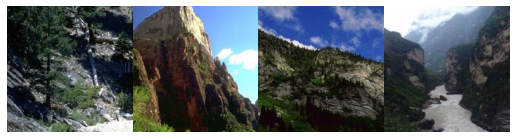

In [102]:
viewGloveImages('ravine', 4, 'Broden')

In [93]:
glove_neighbors

['skies',
 'bright',
 'blue',
 'horizon',
 'darkness',
 'dark',
 'sun',
 'lights',
 'heavens',
 'starry',
 'trees',
 'pine',
 'oak',
 'shrubs',
 'planted',
 'trunks',
 'bark',
 'garden',
 'eucalyptus',
 'shrub',
 'buildings',
 'built',
 'construction',
 'houses',
 'constructed',
 'structure',
 'build',
 'brick',
 'demolished',
 'structures',
 'someone',
 'man',
 'anyone',
 'woman',
 'one',
 'actually',
 'persons',
 'people',
 'else',
 'somebody',
 'heads',
 'assistant',
 'chief',
 'headed',
 'director',
 'deputy',
 'chair',
 'hand',
 'then',
 'former',
 'legs',
 'thigh',
 'knee',
 'ankle',
 'injury',
 'shoulder',
 'wrist',
 'groin',
 'foot',
 'elbow',
 'buttocks',
 'torsos',
 'thighs',
 'abdomen',
 'limbs',
 'pelvis',
 'hips',
 'forearm',
 'extremities',
 'tables',
 'sit',
 'sitting',
 'room',
 'dining',
 'chairs',
 'dinner',
 'side',
 'sat',
 'place',
 'arms',
 'right',
 'hands',
 'finger',
 'chest',
 'roads',
 'route',
 'lane',
 'along',
 'intersection',
 'roadway',
 'junction',
 'hi

---

## Calculate concept scores for the training concepts

Concept scores for transformed SoN images

In [28]:
# calculate the concept scores for the new glove concepts in the latent space for the transformed images
if os.path.exists('../data/training_concepts_latent_concept_score_son.npy'):
    training_latent_concept_score_son = np.load('../data/training_concepts_latent_concept_score_son.npy')
else:
    training_latent_concept_score_son = np.zeros((transformed_imgs.shape[0], len(embedding_concepts)))
    for i in tqdm(range(transformed_imgs.shape[0])):
            for c in range(len(embedding_concepts)):
                concept_score = np.dot(transformed_imgs[i], training_activations[c])
                training_latent_concept_score_son[i][c] = concept_score
                
    np.save('../data/training_concepts_latent_concept_score_son.npy', training_latent_concept_score_son)

Concept scores for transformed Broden images

In [34]:
if os.path.exists('../data/training_concepts_latent_concept_score_broden.npy'):
    training_latent_concept_score_broden = np.load('../data/training_concepts_latent_concept_score_broden.npy')
else:
    training_latent_concept_score_broden = np.zeros((broden_imgs_latent.shape[1], len(embedding_concepts)))
    for i in tqdm(range(broden_imgs_latent.shape[1])):
        for c in range(len(embedding_concepts)):
            concept_score = np.dot(broden_imgs_latent.T[i], training_activations[c])
            training_latent_concept_score_broden[i][c] = concept_score
            
    np.save('../data/training_concepts_latent_concept_score_broden.npy', training_latent_concept_score_broden)

In [86]:
def viewTrainingConceptImages(coi, num_imgs, dataset):
    
    #concept index
    c_idx = embedding_concepts.index(coi)
    
    if dataset == 'SoN':
        # get the n images with the highest concept score
        c_imgs = training_latent_concept_score_son[:,c_idx].argsort()[::-1][:num_imgs]
        ix_imgs = [transformed_ixs[j] for j in c_imgs]
        
        # load image paths:
        paths = []
        for i in ix_imgs:
            img_name = son_info.loc[i, 'ID']
            paths.append('../son_images/images/' + str(img_name) + '.jpg')
        
        savedir = '../images/training_concepts_images/' + coi + '.jpg'
    
    if dataset == 'Broden':
        c_imgs = training_latent_concept_score_broden[:,c_idx].argsort()[::-1][:num_imgs]
        
        broden_paths = list(broden_test.loc[c_imgs, 'image'])
        paths = ['../broden1_384/images/' + i for i in broden_paths]
        
        savedir = '../images/training_concepts_images/' + coi + '_broden.jpg'
    
    # create image figure
    fig = plt.figure(figsize=(9,9))
    ax = [fig.add_subplot(1, num_imgs, i+1) for i in range(num_imgs)]

    for idx, a in enumerate(ax):
        img = Image.open(paths[idx])
        crop_img = img_transform(img)
        crop_img = np.asarray(crop_img)
        a.axis('off')
        a.imshow(crop_img)

    fig.subplots_adjust(wspace=0, hspace=0)
#     plt.savefig(savedir, bbox_inches='tight')
    plt.show()

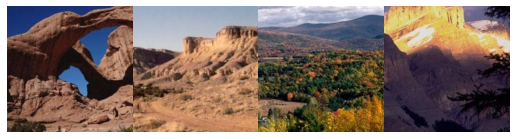

In [85]:
viewTrainingConceptImages('canyon', 4, 'Broden')

In [58]:
embedding_concepts

['sky',
 'tree',
 'building',
 'person',
 'head',
 'leg',
 'torso',
 'table',
 'arm',
 'road',
 'ear',
 'grass',
 'metal',
 'plant',
 'car',
 'neck',
 'carpet',
 'sidewalk',
 'wheel',
 'signboard',
 'mirror',
 'hair',
 'ground',
 'street',
 'bed',
 'box',
 'tail',
 'muzzle',
 'earth',
 'bottle',
 'shelf',
 'water',
 'railing',
 'cushion',
 'book',
 'flower',
 'bedroom',
 'ceramic',
 'rock',
 'seat',
 'paw',
 'pot',
 'sink',
 'dog',
 'food',
 'armchair',
 'body',
 'pillow',
 'headboard',
 'stairs',
 'cat',
 'plate',
 'top',
 'screen',
 'pillar',
 'bicycle',
 'stove',
 'wing',
 'roof',
 'bench',
 'boat',
 'desk',
 'bird',
 'leather',
 'bathroom',
 'plaything',
 'pane',
 'kitchen',
 'sea',
 'balcony',
 'path',
 'stairway',
 'cup',
 'truck',
 'airplane',
 'awning',
 'poster',
 'bush',
 'field',
 'pedestal',
 'fireplace',
 'keyboard',
 'horse',
 'motorbike',
 'train',
 'bathtub',
 'toilet',
 'refrigerator',
 'laminate',
 'counter',
 'wardrobe',
 'computer',
 'palm',
 'bus',
 'sand',
 'track